In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neural_exploration import *

### MDP settings

In [3]:
H = 3
n_states = 2
n_actions = 2
n_features = 8

noise_std = 0.01
reg_factor = 1.0

n_episodes = int(2e2)
n_sim = 1

SEED = 42
np.random.seed(SEED)

### Neural network settings

In [4]:
p = 0.1
hidden_size = 16
n_layers = 2
epochs = 10
confidence_scaling_factor = noise_std
buffer_size = 100
train_every = 1
use_cuda = False

### NeuralUCB-VI on a Linear MDP

In [5]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.dot(x, a)

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                  seed=SEED,
                 )

# to check that backward induction works
mdp.sanity_policy()

In [6]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=hidden_size,
                        n_layers=n_layers,
                        p=p,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=confidence_scaling_factor,
                        learning_rate=0.01,
                        epochs=epochs,
                        train_every=train_every,
                        buffer_size=buffer_size,
                        use_cuda=use_cuda,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/200 [00:00<?, ?it/s, total regret=1.03]/home/sauxpa/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:34<00:00,  5.87it/s, total regret=2.19]


### Sublinear regret growth : kinda working, but unstable

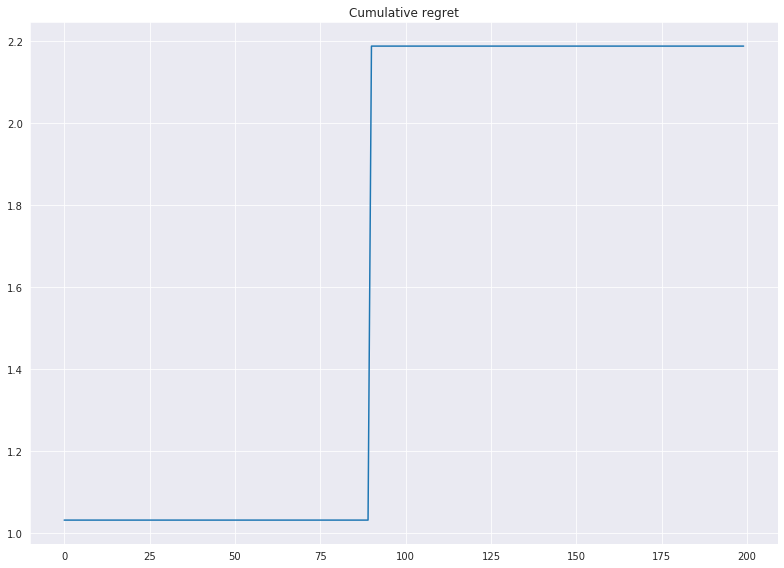

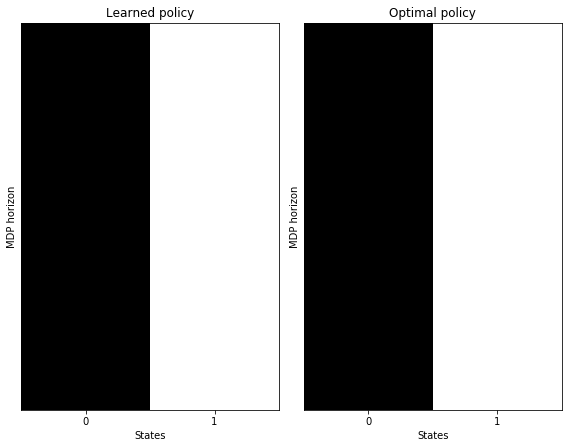

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

    t = np.arange(n_episodes)
    mean_regrets = np.mean(regrets, axis=0)
    std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
    ax.plot(mean_regrets)
    ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    ax.set_title('Cumulative regret')

    plt.tight_layout()
    plt.show()

    fig.savefig('figures/neural_ucbvi_linear.pdf')

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)
ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucbvi_linear_policy.pdf')

### NeuralUCB-VI on a Linear transition/quadratic reward MDP

In [8]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: 2*np.dot(x, a)**2

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                 )

# to check that backward induction works
mdp.sanity_policy()

In [9]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=hidden_size,
                        n_layers=n_layers,
                        p=p,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=confidence_scaling_factor,
                        learning_rate=0.01,
                        epochs=epochs,
                        train_every=train_every,
                        buffer_size=buffer_size,
                        use_cuda=use_cuda,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/200 [00:00<?, ?it/s, total regret=0]/home/sauxpa/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:35<00:00,  5.66it/s, total regret=1.18] 


### Still sublinear growth

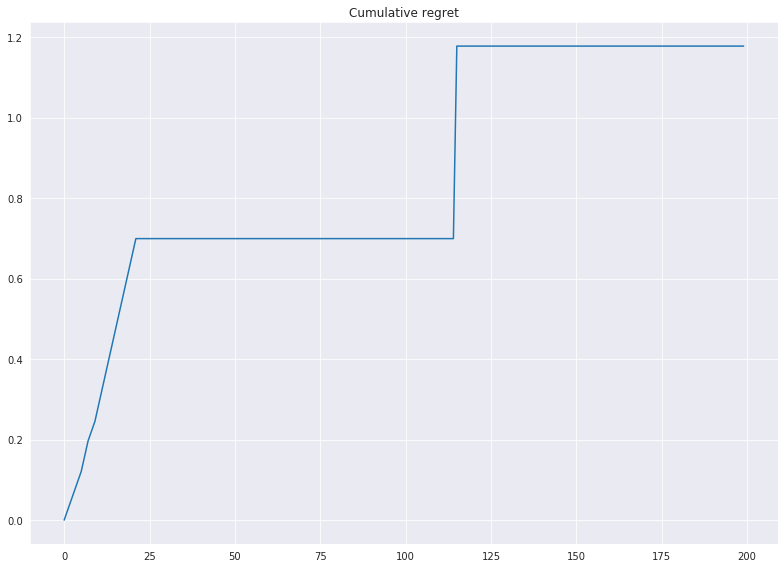

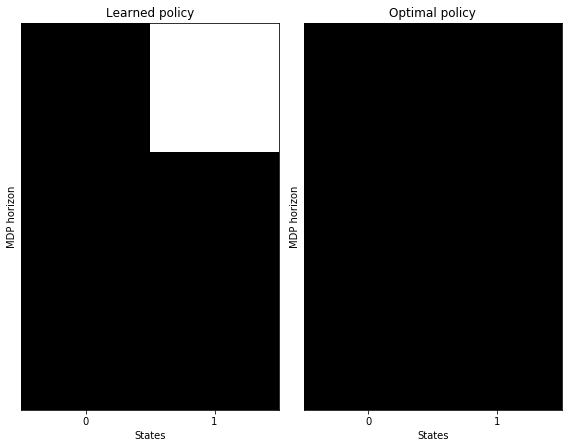

In [10]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

    t = np.arange(n_episodes)
    mean_regrets = np.mean(regrets, axis=0)
    std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
    ax.plot(mean_regrets)
    ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    ax.set_title('Cumulative regret')

    plt.tight_layout()
    plt.show()

    fig.savefig('figures/neural_ucbvi_quad.pdf')

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)
ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucbvi_quad_policy.pdf')

### NeuralUCB-VI on a Linear transition/nonlinear reward MDP

In [11]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.cos(10*np.pi*np.dot(x, a))

mdp = MDPFeatures(H,
                  n_states=n_states,
                  n_actions=n_actions,
                  n_features=n_features,
                  reward_func=reward_func,
                  noise_std=noise_std,
                  )

# to check that backward induction works
mdp.sanity_policy()

In [12]:
regrets = np.empty((n_sim, n_episodes))

for i in range(n_sim):
    mdp.reset_rewards()
    model = NeuralUCBVI(mdp,
                        hidden_size=hidden_size,
                        n_layers=n_layers,
                        p=p,
                        n_episodes=n_episodes,
                        init_state=0,
                        reg_factor=reg_factor,
                        confidence_scaling_factor=confidence_scaling_factor,
                        learning_rate=0.01,
                        epochs=epochs,
                        train_every=train_every,
                        buffer_size=buffer_size,
                        use_cuda=use_cuda,
                       )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/200 [00:00<?, ?it/s, total regret=2.71]/home/sauxpa/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:40<00:00,  4.98it/s, total regret=4.19]


### Sublinear growth, but not very stable

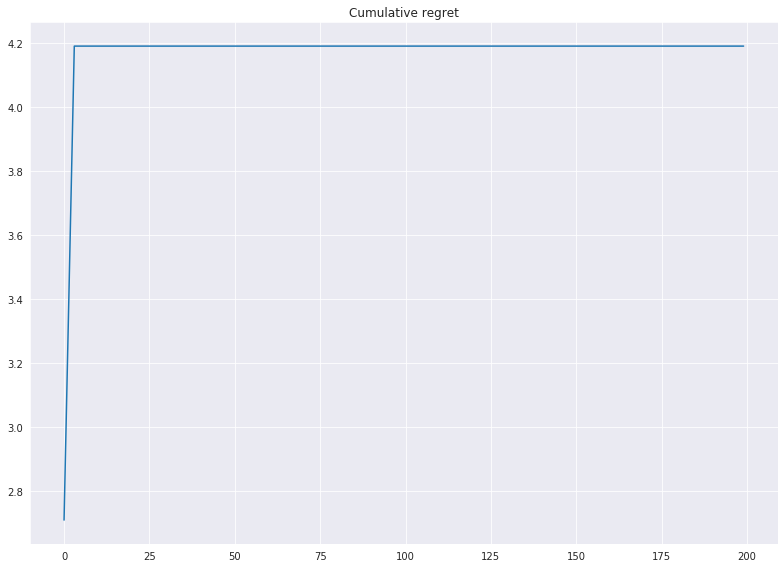

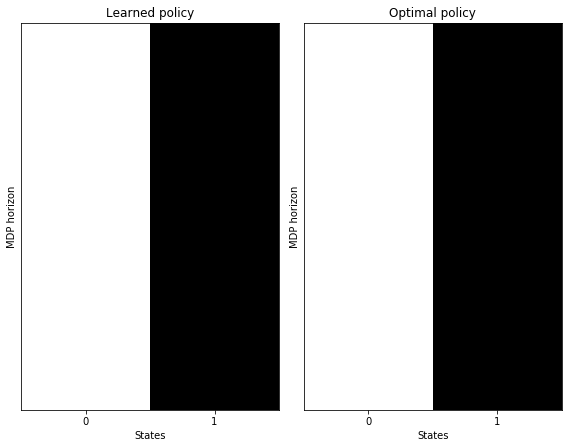

In [13]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 8), nrows=1, ncols=1)

    t = np.arange(n_episodes)
    mean_regrets = np.mean(regrets, axis=0)
    std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
    ax.plot(mean_regrets)
    ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    ax.set_title('Cumulative regret')

    plt.tight_layout()
    plt.show()

    fig.savefig('figures/neural_ucbvi_cosine.pdf')

fig, axes = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)
ax = axes[0]
ax.imshow(model.policy, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Learned policy')

ax = axes[1]
ax.imshow(model.pi_star, cmap='gray', vmin=0, vmax=mdp.n_actions-1)
ax.set_xticks(range(mdp.n_states))
ax.set_xlabel('States')
ax.set_yticks([])
ax.set_ylabel('MDP horizon')
ax.set_title('Optimal policy')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucbvi_cosine_policy.pdf')